In [1]:
# utils functions

import pathlib
import shutil
import os
import time
import datetime 
import numpy as np
import wandb
import tensorflow as tf
import matplotlib.pyplot as plt
import zipfile

from typing import List

import pandas as pd
import pathlib

import matplotlib.pyplot as plt
import seaborn as sns

def load_data(run, artifact_name = "phcd_paper_splits_tfds") -> List[tf.data.Dataset]:
    """
    Downloads datasets from a wandb artifact and loads them into a list of tf.data.Datasets.
    """

    artifact = run.use_artifact(f"master-thesis/{artifact_name}:latest")
    artifact_dir = pathlib.Path(
        f"./artifacts/{artifact.name.replace(':', '-')}"
    ).resolve()
    if not artifact_dir.exists():
        artifact_dir = artifact.download()
        artifact_dir = pathlib.Path(artifact_dir).resolve()

    # if tf.__version__ minor is less than 10, use
    # tf.data.experimental.load instead of tf.data.Dataset.load

    if int(tf.__version__.split(".")[1]) < 10:
        load_function = tf.data.experimental.load
    else:
        load_function = tf.data.Dataset.load
    
    output_list = []
    for split in ["train", "test", "val"]:
        ds = load_function(str(artifact_dir / split), compression="GZIP")
        output_list.append(ds)
    
    return output_list

def get_readable_class_labels(subset = 'phcd_paper'):
    if subset == 'phcd_paper':
        return ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c',
        'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
        'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C',
        'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
        'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'ą', 'ć', 'ę',
        'ł', 'ń', 'ó', 'ś', 'ź', 'ż', 'Ą', 'Ć', 'Ę', 'Ł', 'Ń', 'Ó', 'Ś',
        'Ź', 'Ż', '+', '-', ':', ';', '$', '!', '?', '@', '.']
    elif subset == 'uppercase':
        return ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 
        'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'Ą', 'Ć', 
        'Ę', 'Ł', 'Ń', 'Ó', 'Ś', 'Ź', 'Ż']
    elif subset == 'lowercase':
        return ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
        'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ą', 'ć',
        'ę', 'ł', 'ń', 'ó', 'ś', 'ź', 'ż']
    elif subset == 'numbers':
        return ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    elif subset == 'uppercase_no_diacritics':
        return ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
        'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
    elif subset == 'lowercase_no_diacritics':
        return ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
        'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

def calculate_accuracy_per_class(model, test_dataset, test_dataset_name):
    '''
    Calculates the accuracy per class for a given model and test dataset.

    Returns dict with class labels as keys and accuracy as values.
    '''
        
    y_pred = model.predict(test_dataset)
    y_pred = np.argmax(y_pred, axis=1)
    # get labels
    y_true = test_dataset.map(lambda x, y: y).as_numpy_iterator()
    y_true = np.concatenate(list(y_true))
    # calculate accuracy per class
    labels = get_readable_class_labels(test_dataset_name)
    class_accuracy = np.zeros(len(labels))
    for i, label in enumerate(labels):
        class_accuracy[i] = np.sum(y_pred[y_true == i] == i) / np.sum(y_true == i)
    return { label: acc for label, acc in zip(labels, class_accuracy) }
    

def plot_accuracy_per_class(class_accuracy_dict):
    plt.figure(figsize=(10, 5))
    labels = list(class_accuracy_dict.keys())
    class_accuracy = list(class_accuracy_dict.values())
    plt.bar(labels, class_accuracy)
    plt.xticks(labels)
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per class")
    plt.show()


def accuracy_table(class_accuracy_dict):
    labels = list(class_accuracy_dict.keys())
    class_accuracy = list(class_accuracy_dict.values())
    return wandb.Table(columns=["Class", "Accuracy"], data=list(zip(labels, class_accuracy)))

def get_number_of_classes(ds: tf.data.Dataset) -> int:
    """
    Returns the number of classes in a dataset.
    """
    labels_iterator= ds.map(lambda x, y: y).as_numpy_iterator()
    labels = np.concatenate(list(labels_iterator))
    return len(np.unique(labels))

def get_number_of_examples(ds: tf.data.Dataset) -> int:
    """
    Returns the number of examples in a dataset.
    """
    return sum(1 for _ in ds)

def preprocess_dataset(ds: tf.data.Dataset, batch_size: int, cache: bool = True) -> tf.data.Dataset:
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))  # normalize
    ds = ds.unbatch().batch(batch_size)
    if cache:
        ds = ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

def calculate_model_compressed_size_on_disk(path: str) -> int:
    compressed_path = path + ".zip"
    with zipfile.ZipFile(compressed_path, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(path)
    return pathlib.Path(compressed_path).stat().st_size    

def calculate_model_size_on_disk(path: str) -> int:
    return pathlib.Path(path).stat().st_size

def calculate_model_num_parameters(model: tf.keras.Model) -> int:
    return model.count_params()

def calculate_model_flops(summary) -> float:
    # from run.summary get GFLOPs or GFLOPS whichever is available
    if "GFLOPs" in summary.keys():
        return summary.get("GFLOPs")
    elif "GFLOPS" in summary.keys():
        return summary.get("GFLOPS")
    else:
        return 0
    
def plot_history(history, title):
    plt.figure(figsize=(15,7))
    plt.suptitle(title)
    
    plt.subplot(121)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()

2023-03-24 07:23:35.497567: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-24 07:23:35.720397: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-24 07:23:35.721384: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 07:23:36.605128: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
defaults = dict(
    batch_size=32*2,
    epochs=60,    
    optimizer="adam"
)

artifact_base_name = "phcd_paper"
artifact_name = f"{artifact_base_name}_splits_tfds" # "phcd_paper_splits_tfds
arch_short_name = "arch-1"
run = wandb.init(project="master-thesis", job_type="model-optimization",  config=defaults, tags=["optimization"])

# hyperparameters
epochs = wandb.config.epochs
bs = wandb.config.batch_size

ds_train, ds_test, ds_val = load_data(run, artifact_name=artifact_name)

num_classes = get_number_of_classes(ds_val)

ds_train_non_normalized = ds_train.unbatch().batch(64).take(2000)


ds_train = preprocess_dataset(ds_train, batch_size=bs)
ds_val = preprocess_dataset(ds_val, batch_size=bs)
ds_test = preprocess_dataset(ds_test, batch_size=bs, cache=False).take(1743).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# labels
labels = get_readable_class_labels(artifact_name)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /home/wiktor/.netrc


wandb:   9 of 9 files downloaded.  
2023-03-24 07:31:15.046706: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-03-24 07:31:15.047113: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [109]:
import random

sns.set_style("whitegrid")

project_name = "master-thesis"

def get_runs(project_name, run_name):
    """
    Returns all runs with a given name in a given project.
    """
    api = wandb.Api()
    runs = api.runs(
        project_name, {
            "$and": [
                {"displayName": run_name},
                {"state": "finished"},
                {"tags": "phcd_paper_splits_tfds"}
                ]
            })
    return [run.id for run in runs]

def get_model_from_run(run_id, project_name="master-thesis"):
    # from project run_id artifacts get file_name
    api = wandb.Api()
    run = api.run(f"{project_name}/{run_id}")
    # download file config.yaml
    run.file("config.yaml").download(replace=True)
    artifact = run.file("model_baseline.h5").download(replace=True)
    model = tf.keras.models.load_model(artifact.name, compile=False)
    return model, pathlib.Path(artifact.name)

run_name = "architecture-2"
run_ids = get_runs(project_name, run_name)

arch_2_run_id = random.choice(run_ids)

run_name = "architecture-7"
run_ids = get_runs(project_name, run_name)

arch_7_run_id = random.choice(run_ids)


run_name = "architecture-baseline"
run_ids = get_runs(project_name, run_name)

arch_baseline_run_id = random.choice(run_ids)

In [6]:
model_arch_7, model_path_arch_7 = get_model_from_run(arch_7_run_id, project_name)
model_arch_7.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [7]:
model_arch_2, model_path_arch_2 = get_model_from_run(arch_2_run_id, project_name)
model_arch_2.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [110]:
model_baseline, model_path_baseline = get_model_from_run(arch_baseline_run_id, project_name)
model_baseline.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [111]:
model_baseline.layers

In [47]:
model_arch_7.layers

In [89]:
model_arch_2.layers

In [101]:
layer_name_1 = model_arch_7.layers[0].name
layer_name_2 = model_arch_7.layers[3].name
layer_name = model_arch_7.layers[6].name

layer_name = model_arch_2.layers[0].name



2023-03-24 08:53:33.943512: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-24 08:53:33.969231: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


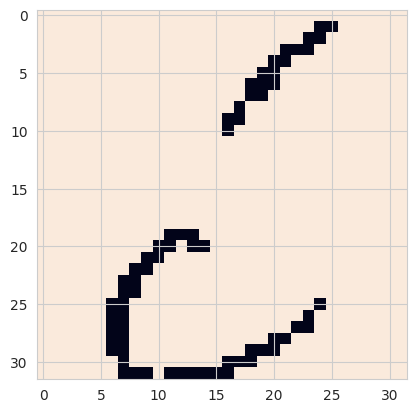

In [151]:
# take random image from ds_train_non_normalized.unbatch().
ds_train.unbatch().take(10).as_numpy_iterator().next()

images = ds_train.unbatch().take(10).as_numpy_iterator()

letter_img, _ = [ image for image in images][7]
# take 8th element

# plot img
plt.imshow(letter_img)

In [152]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# The dimensions of our input image
img_width = 32
img_height = 32

layer_name = model_baseline.layers[5].name
# Set up a model that returns the activation values for our target layer
layer = model_baseline.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model_baseline.inputs, outputs=layer.output)

letter_img_tensor = tf.convert_to_tensor(letter_img)

def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)


@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img


def initialize_image():

    img = tf.random.uniform((1, img_width, img_height, 1))
    # scale to [0, 1]
    img = np.array(img)

    # scale to [0, 1]
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    
    return img#(img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)
    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    #img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    #img *= 255
    #img = np.clip(img, 0, 255).astype("uint8")
    return img


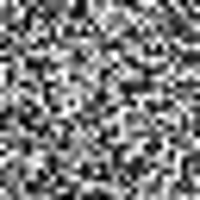

In [153]:
from PIL import Image

loss, img = visualize_filter(0)
keras.preprocessing.image.save_img("0.png", img)
Image.open("0.png").resize((200, 200))

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

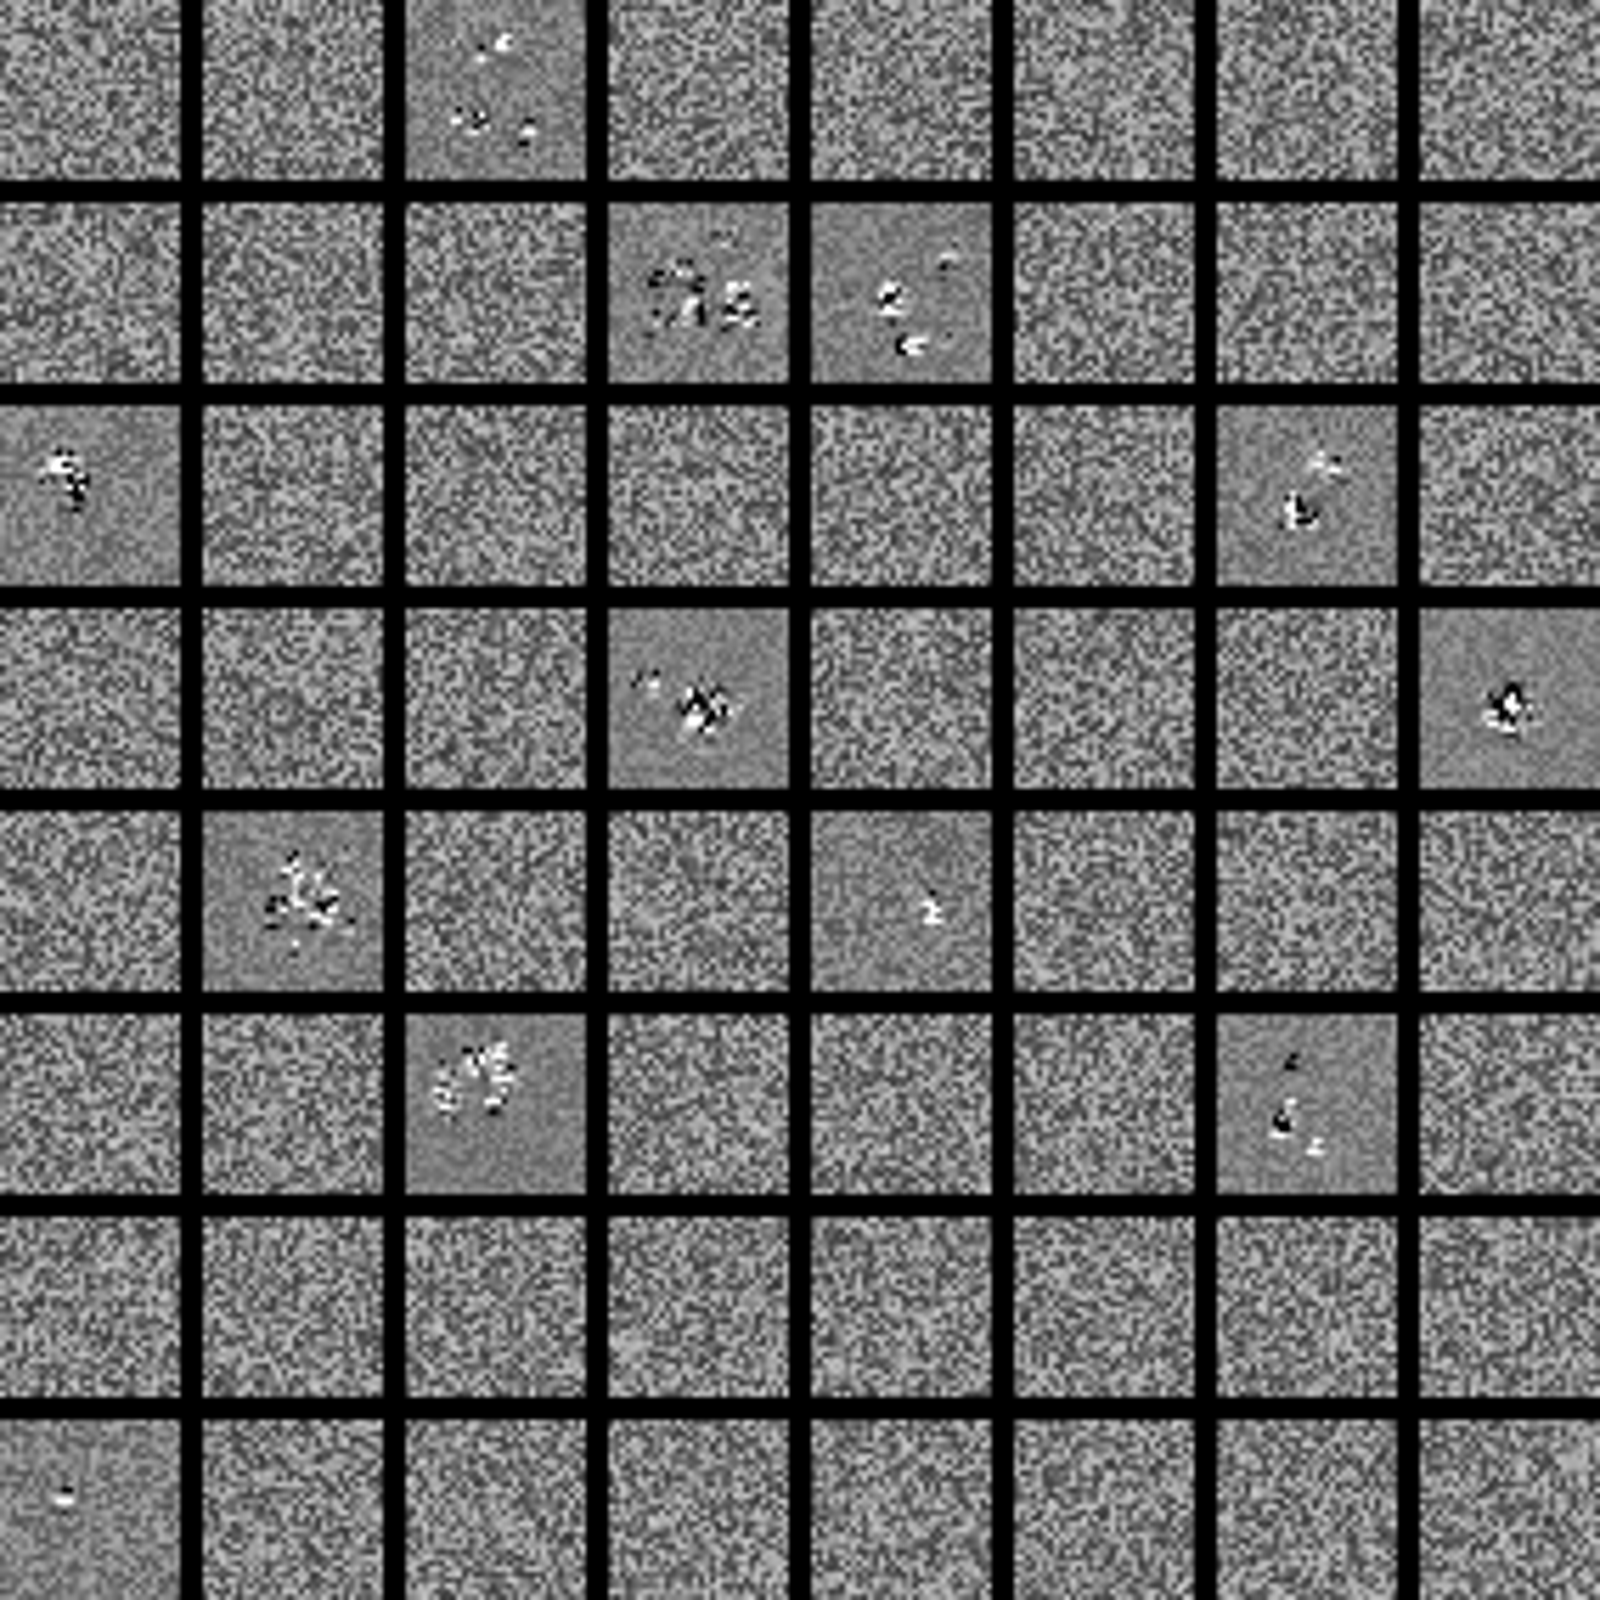

In [154]:
# Compute image inputs that maximize per-filter activations
# for the first 64 filters of our target layer
all_imgs = []
for filter_index in range(64):
    print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

# Build a black picture with enough space for
# our 8 x 8 filters of size 32 x 32, with a 4px margin in between

n = 8
cropped_width = 32
cropped_height = 32
margin = 4

stitched_filters = np.zeros(
    (cropped_width * n + margin * (n - 1), cropped_height * n + margin * (n - 1), 3)
)


# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img

# create a PIL image

keras.preprocessing.image.save_img("stiched_filters.png", stitched_filters)

#display(Image("stiched_filters.png"))
Image.open("stiched_filters.png").resize((200*8, 200*8))

In [ ]:
ds_train_non_normalized